In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import scienceplots
import matplotlib as mpl
from sklearn.metrics import root_mean_squared_error
mpl.rcParams['font.family'] = 'serif'

In [2]:
# Generate 1e6 random numbers between 0 and 5 
# make 1000 bins from 0-5  
# probability distribution is the number of values at least > min val of bin
tau_array = [-np.log(1-random.uniform(0, 1)) for i in range(1000000)]

# Make 100 clouds of layers 1-100 
# for each # of layers, count how many photons are transmitted and how many reflected
optical_depths = np.arange(0, 101, 1)

# set up constants & counts, init empty arrays 
g = 0.85 # from class
prob_back = (1-g)*0.5 # probability backscatter (low prob)
prob_fwd = (1+g)*0.5 # probability forward scatter (high prob)

In [3]:
hist, bin_edges = np.histogram(tau_array, bins=1000)
bin_width = bin_edges[1] - bin_edges[0]

In [4]:
prob_distribution = hist * bin_width
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
cumulative_prob = np.cumsum(prob_distribution)
ccdf = 1 - cumulative_prob/cumulative_prob[-1] # get cumulative prob dist

Text(0.0, 1.0, 'matching fig 6.4 in book')

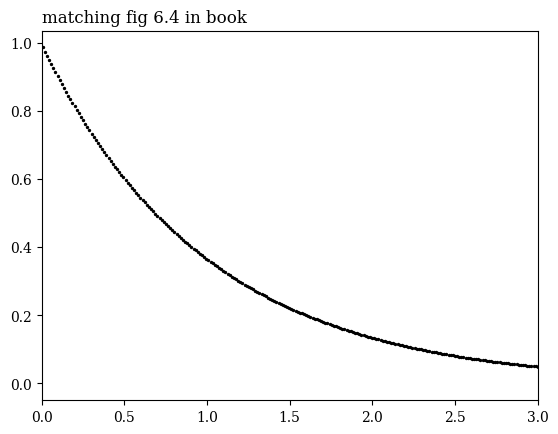

In [5]:
plt.scatter(bin_centers, ccdf, s=2, color="black", label="calculated")
plt.xlim(0, 3)
plt.title("matching fig 6.4 in book", loc="left")

In [6]:
# generate theoretical values
R_theory=[]
T_theory=[]
for cloud in optical_depths:
    Rt_value = cloud/(cloud+13)
    Tt_value = 1/(1+(cloud*prob_back))
    R_theory.append(Rt_value)
    T_theory.append(Tt_value)

In [7]:
# scattering function
def scatter(tau, tau_array, dirscat, optd, numT, numR):
    '''
    If photon is not transmitted (T), reflected (R), or absorbed (A)
    let it keep scattering until it is T, R, or A
    '''
    # if photon has not scattered or reflected, keep doing it
    while 0 < tau < optd:
        scattau = random.choice(tau_array)
        if prob_fwd>=np.random.uniform():
            tau = tau + dirscat*scattau
            dirscat = dirscat # keep track of the direction of scattering from the original
        else: 
            tau = tau - dirscat*scattau
            dirscat = -dirscat # keep track of the direction of scattering from the original
            
        
        if tau >= optd: numT = numT + 1; dirscat=1; break 
        if tau <= 0: numR = numR + 1; dirscat=1; break 
    
    return numR, numT

In [8]:
def count_RTA(tau_array, num_sims = 1000, optical_depths = optical_depths, g=g, prob_back=prob_back, prob_fwd=prob_fwd):
    '''
    Run montecarlo, keeping track of photons reflected, transmitted, and absorbed
    '''
    
    numR = 0; numT = 0; numA = 0 # set number reflected (R) and transmitted (T) and absorbed (A)
    R_array = [] # array of numR
    T_array = [] # array of numT
    dirscat = 1 # keep track of the direction of scattering where 1 is forward and -1 is back

    
    for optd in optical_depths: 
        for sim in range(num_sims):
            # get a tau value
            tau = random.choice(tau_array)
            if tau >= optd: numT = numT + 1; continue 
            if tau <= 0: numR = numR + 1; continue 
            # keep scattering until reflected, transmitted, or absorbed
            numR, numT = scatter(tau, tau_array, dirscat, optd, numT, numR)
                
        R_array.append(numR/num_sims)
        T_array.append(numT/num_sims)
        numR=0
        numT=0

    return R_array, T_array

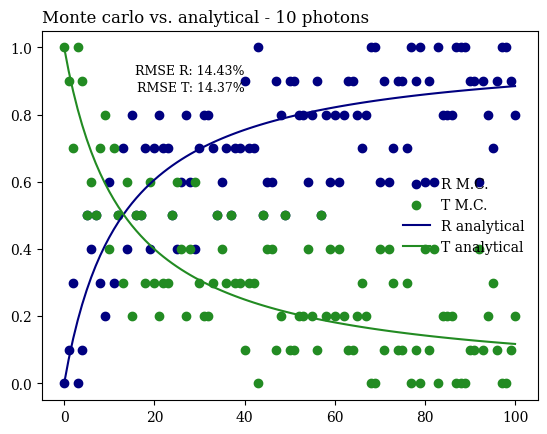

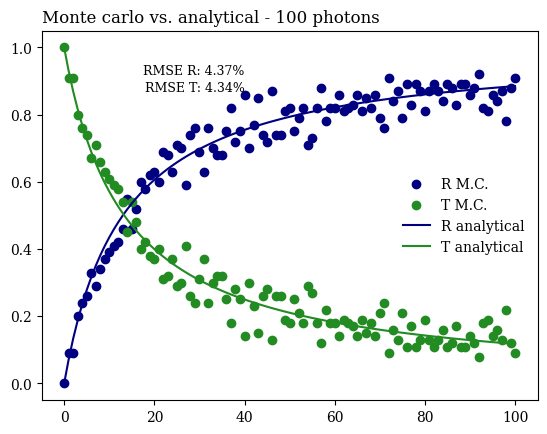

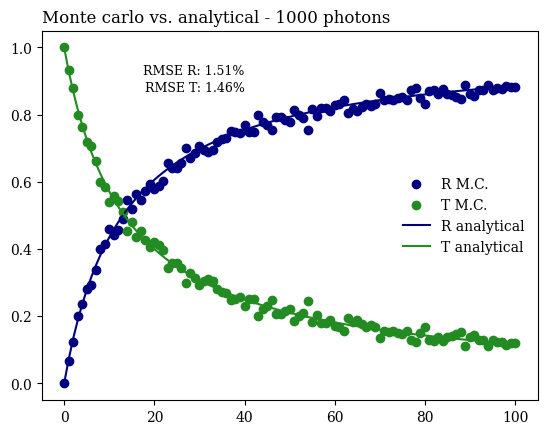

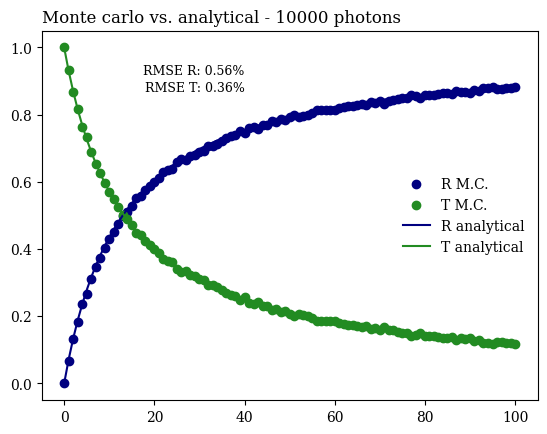

In [13]:
for num_sims in [1e1, 1e2, 1e3, 1e4]:
    # get % scattered vs. transmitted
    R_array, T_array = count_RTA(tau_array, int(num_sims))

    # get rmse from analytical
    rmse_R = root_mean_squared_error(R_theory, R_array)
    rmse_T = root_mean_squared_error(T_theory, T_array)
    
    plt.scatter(optical_depths, R_array, label="R M.C.", color="navy")
    plt.scatter(optical_depths, T_array, label="T M.C.", color="forestgreen")
    plt.plot(optical_depths, R_theory, label="R analytical",color="navy")
    plt.plot(optical_depths, T_theory, label="T analytical", color="forestgreen")
    plt.title(f"Monte carlo vs. analytical - {int(num_sims)} photons", loc="left")
    plt.legend(frameon=False)
    
    # plt.text(40, 0.95, f'RMSE R: {"{:.2e}".format(rmse_R)}', fontsize=9, ha='right', va='top')
    # plt.text(40, 0.9, f'RMSE T: {"{:.2e}".format(rmse_T)}', fontsize=9, ha='right', va='top')
    plt.text(40, 0.95, f'RMSE R: {round(rmse_R*100, 2)}%', fontsize=9, ha='right', va='top')
    plt.text(40, 0.9, f'RMSE T: {round(rmse_T*100, 2)}%', fontsize=9, ha='right', va='top')
    plt.show()

## add absorption

In [14]:
# scattering function
def scatter(tau, tau_array, dirscat, optd, numT, numR, numA):
    '''
    If photon is not transmitted (T), reflected (R), or absorbed (A)
    let it keep scattering until it is T, R, or A
    '''
    # if photon has not scattered or reflected, keep doing it
    while 0 < tau < optd:
        # check if photon is absorbed
        if random.uniform(0, 1) > omega:
            numA = numA + 1; dirscat=1; break
        scattau = random.choice(tau_array)
        if prob_fwd>=np.random.uniform():
            tau = tau + dirscat*scattau
            dirscat = dirscat # keep track of the direction of scattering from the original
        else: 
            tau = tau - dirscat*scattau
            dirscat = -dirscat # keep track of the direction of scattering from the original
            
        
        if tau >= optd: numT = numT + 1; dirscat=1; break 
        if tau <= 0: numR = numR + 1; dirscat=1; break 
    
    return numR, numT, numA

In [15]:
def count_RTA(tau_array, num_sims = 1000, optical_depths = optical_depths, g=g, prob_back=prob_back, prob_fwd=prob_fwd):
    '''
    Run montecarlo, keeping track of photons reflected, transmitted, and absorbed
    '''
    
    numR = 0; numT = 0; numA = 0 # set number reflected (R) and transmitted (T) and absorbed (A)
    R_array = [] # array of numR
    T_array = [] # array of numT
    A_array = [] # array of numA
    dirscat = 1 # keep track of the direction of scattering where 1 is forward and -1 is back

    
    for optd in optical_depths: 
        for sim in range(num_sims):
            # get a tau value
            tau = random.choice(tau_array)
            if tau >= optd: numT = numT + 1; continue 
            if tau <= 0: numR = numR + 1; continue 
            # keep scattering until reflected, transmitted, or absorbed
            numR, numT, numA = scatter(tau, tau_array, dirscat, optd, numT, numR, numA)
                
        R_array.append(numR/num_sims)
        T_array.append(numT/num_sims)
        A_array.append(numA/num_sims)
        numR=0
        numT=0
        numA=0

    return R_array, T_array, A_array

In [16]:
num_sims=1e3
omega=0.99
R_array, T_array, A_array = count_RTA(tau_array, int(num_sims))

In [17]:
sum_rta = [x + y + z for x, y, z in zip(R_array, T_array, A_array)]
min(sum_rta) # min is somehow not exactly 1, but ignore for now 

0.9999999999999999

In [18]:
max(sum_rta)

1.0

In [19]:
# analytical solution for 2 stream w/ absorption
num_sims=10000
R_analytical = []
T_analytical = []
A_analytical = []
for tau_max in np.arange(0, 101, 1):
    K = np.sqrt((1-omega)*(1-g*omega))
    R_inf = (np.sqrt(1-omega*g)-np.sqrt(1-omega))/(np.sqrt(1-omega*g)+np.sqrt(1-omega))
    R_g = 0.0
    F0 = num_sims
    A_bar = F0*(R_inf-R_g)*np.exp(-K*tau_max)/(R_inf*(R_inf-R_g)*np.exp(-K*tau_max)-(1-R_inf*R_g)*np.exp(K*tau_max))
    B_bar = -F0*(1-R_inf*R_g)*np.exp(K*tau_max)/(R_inf*(R_inf-R_g)*np.exp(-K*tau_max)-(1-R_inf*R_g)*np.exp(K*tau_max))
    R = (A_bar*np.exp(K*0) + B_bar*R_inf*np.exp(-K*0))/num_sims
    T = (A_bar*R_inf*np.exp(K*tau_max) + B_bar*np.exp(-K*tau_max))/num_sims
    A = 1 - R - T

    R_analytical.append(R)
    T_analytical.append(T)
    A_analytical.append(A)

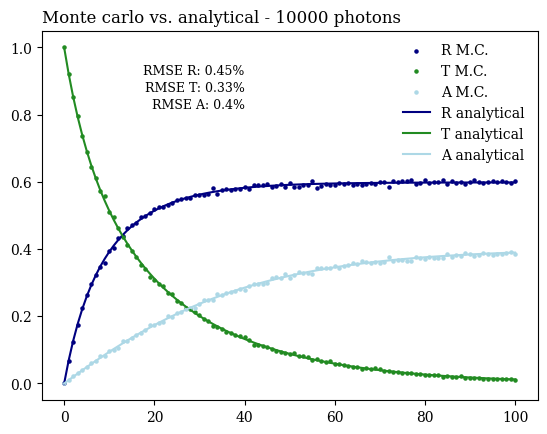

In [21]:
# get % scattered vs. transmitted
R_array, T_array, A_array = count_RTA(tau_array, int(num_sims))

# get rmse from analytical
rmse_R = root_mean_squared_error(R_analytical, R_array)
rmse_T = root_mean_squared_error(T_analytical, T_array)
rmse_A = root_mean_squared_error(A_analytical, A_array)

plt.scatter(optical_depths, R_array, label="R M.C.", s=5, color="navy")
plt.scatter(optical_depths, T_array, label="T M.C.", s=5, color="forestgreen")
plt.scatter(optical_depths, A_array, label="A M.C.", s=5, color="lightblue")
plt.plot(optical_depths, R_analytical, label="R analytical", color="navy")
plt.plot(optical_depths, T_analytical, label="T analytical", color="forestgreen")
plt.plot(optical_depths, A_analytical, label="A analytical", color="lightblue")
plt.title(f"Monte carlo vs. analytical - {int(num_sims)} photons", loc="left")
plt.legend(frameon=False)

# plt.text(40, 0.95, f'RMSE R: {"{:.2e}".format(rmse_R)}', fontsize=9, ha='right', va='top')
# plt.text(40, 0.9, f'RMSE T: {"{:.2e}".format(rmse_T)}', fontsize=9, ha='right', va='top')
# plt.text(40, 0.85, f'RMSE A: {"{:.2e}".format(rmse_A)}', fontsize=9, ha='right', va='top')
plt.text(40, 0.95, f'RMSE R: {round(100*rmse_R, 2)}%', fontsize=9, ha='right', va='top')
plt.text(40, 0.9, f'RMSE T: {round(rmse_T*100, 2)}%', fontsize=9, ha='right', va='top')
plt.text(40, 0.85, f'RMSE A: {round(100*rmse_A, 2)}%', fontsize=9, ha='right', va='top')
plt.show()